# Laboratorio 2: Armado de un esquema de aprendizaje automático
---
- Ashley Quezada 
- Matias Ugrin 
- Nicolas E Ponce
- Sergio Sulca
- Gustavo Álvarez
- Julieta Borre
---


En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

sns.set_context(context='talk', font_scale=1.2)

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
#lo abro desde el github
url='https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv' 
#pd.set_option('display.max_columns', 13)
ds = pd.read_csv(url,comment="#")
ds

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea
---
Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

### 1.¿De qué se trata el conjunto de datos?

El conjunto de datos trata sobre datos recopilados de solicitantes a los que se les otorgó crédito a través del proceso actual de suscripción de préstamos. El departamento de crédito al consumo de un banco desea automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria.


### 2.¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

TARGET Etiqueta: 1 = Cliente no cumplio con el prestamo - 0 = Prestamo Pagado.

Queremos desarrollar un modelo que predice si una persona será capaz de reembolsar el préstamo o no.

### 3. ¿Qué información (atributos) hay disponible para hacer la predicción?

Attributes

Name    Description
 * `TARGET`  Label: 1 = client defaulted on loan - 0 = loan repaid
 * `LOAN`    Amount of the loan request
 * `MORTDUE` Amount due on existing mortgage
 * `VALUE`   Value of current property
 * `YOJ`     Years at present job
 * `DEROG`   Number of major derogatory reports
 * `DELINQ`  Number of delinquent credit lines
 * `CLAGE`   Age of oldest trade line in months
 * `NINQ`    Number of recent credit lines
 * `CLNO`    Number of credit lines
 * `DEBTINC` Debt-to-income ratio

### 4.¿Qué atributos imagina ud. que son los más determinantes para la predicción?

En primer lugar el atributo `DELINQ`, ya que este implica que el cliente posee deudas de otros prestamos, en segundo lugar `DEROG`, el cual implica que el cliente posee informes negativos, y finalmente `DEBTINC` ya que si el cliente tiene una relacion deduda ingresos muy alta, tiene poco margen de pago.




## Ejercicio 2: Predicción con Modelos Lineales
----

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


#### Analisis previo

Como se puede ver el grafico `countplot` el `TARGET` se encuentra desbalanceados, ya que existen mas datos para cliente que pagaron los prestamos `0`, que para aquellos que los incumplieron `1`.

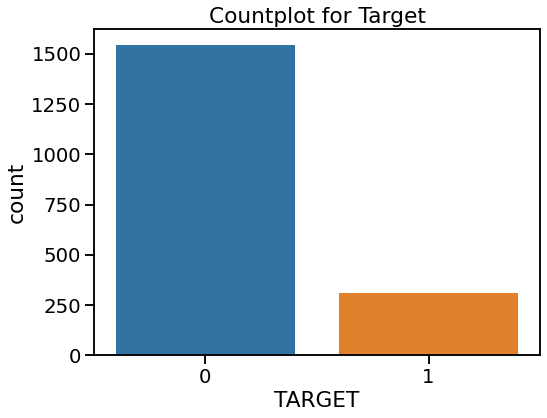

In [3]:
plt.figure(figsize=(8, 6))
sns.countplot(x=ds.TARGET)
plt.title('Countplot for Target')
plt.show()

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [4]:
# División entre instancias y etiquetas
X, y = ds.iloc[:, 1:], ds.TARGET
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [5]:
random_state = np.random.RandomState(0)

default_model = make_pipeline(
    StandardScaler(), SGDClassifier(random_state=random_state))

default_model.fit(X_train, y_train)

y_train_pred = default_model.predict(X_train)
y_test_pred = default_model.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.65      0.34      0.45        58

    accuracy                           0.87       371
   macro avg       0.77      0.65      0.69       371
weighted avg       0.85      0.87      0.85       371



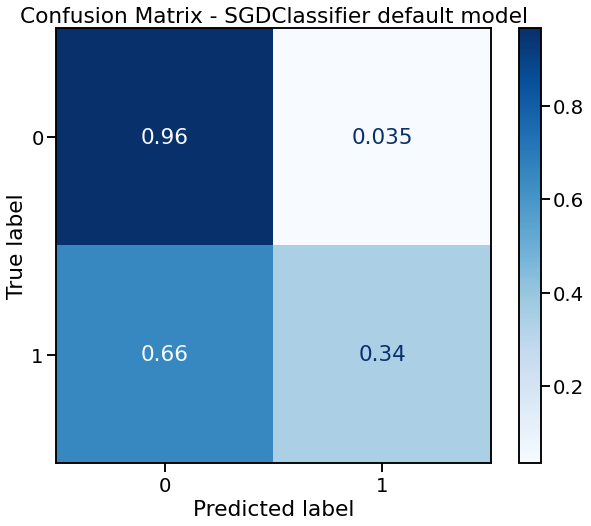

In [6]:
# confusion_matrix
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_confusion_matrix(
    default_model, X_test, y_test,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax)

plt.title('Confusion Matrix - SGDClassifier default model')
plt.show()

Devido al desbalance presente el dataset hacia la clase 0.   El modelo por defecto predice mayormente como positivo lo que produce un recall bajo para la clase 1 como se puede ver en Classification Report, y tambien da como resultado una gran cantidad de falsos negativos, como se observa en la Matriz de confusion. 

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)  # apply same transformation to test data

Se usa `GridSearchCV` con `scoring='f1'`, ya que f1 se una buena metrica cuando se tiene una clasificacion binaria desbalanceada, el objetivo aumentar el valor del `recall` para la calse 1.

In [8]:
fold = 5
param_grid = {
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0':  [0.0001], # np.logspace(-1, -4, 4),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-1, -4, 4),
    'loss':[ 'hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
            'squared_loss', 'huber', 'epsilon_insensitive', 
            'squared_epsilon_insensitive'],
}

random_state = np.random.RandomState(0)
model = SGDClassifier(random_state=random_state)
# f1 	for binary targets
sgdc = GridSearchCV(model, param_grid, scoring='f1', cv=fold)
sgdc.fit(X_train_s, y_train);

/home/sergio/.cache/pypoetry/virtualenvs/introml-xFKGmq4R-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/sergio/.cache/pypoetry/virtualenvs/introml-xFKGmq4R-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/sergio/.cache/pypoetry/virtualenvs/introml-xFKGmq4R-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/sergio/

#### 2.2.1 Reportar accuracy promedio y varianza para todas las configuraciones.

In [9]:
res_df = pd.DataFrame(sgdc.cv_results_)

cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
results = res_df[cols].sort_values(by=['rank_test_score']).head(10)
results

,rank_test_score,mean_test_score,std_test_score,params
147,1,0.497688,0.042212,"{'alpha': 0.01, 'eta0': 0.0001, 'learning_rate..."
249,2,0.464532,0.065940,"{'alpha': 0.001, 'eta0': 0.0001, 'learning_rat..."
356,3,0.463630,0.040696,"{'alpha': 0.0001, 'eta0': 0.0001, 'learning_ra..."
351,4,0.462677,0.072206,"{'alpha': 0.0001, 'eta0': 0.0001, 'learning_ra..."
201,5,0.460829,0.054619,"{'alpha': 0.01, 'eta0': 0.0001, 'learning_rate..."
359,6,0.460655,0.130555,"{'alpha': 0.0001, 'eta0': 0.0001, 'learning_ra..."
417,7,0.459294,0.051131,"{'alpha': 0.0001, 'eta0': 0.0001, 'learning_ra..."
93,8,0.451805,0.056218,"{'alpha': 0.1, 'eta0': 0.0001, 'learning_rate'..."
358,9,0.450101,0.060830,"{'alpha': 0.0001, 'eta0': 0.0001, 'learning_ra..."
250,10,0.449869,0.036388,"{'alpha': 0.001, 'eta0': 0.0001, 'learning_rat..."


In [10]:
best_model = sgdc.best_estimator_
print(best_model)

SGDClassifier(alpha=0.01, eta0=0.0001, loss='perceptron',
              random_state=RandomState(MT19937) at 0x7F9367EFC340)


In [11]:
y_train_pred_b = best_model.predict(X_train_s)
y_test_pred_b = best_model.predict(X_test_s)

print('default model')
print(classification_report(y_test, y_test_pred))
print('------------------------------------------')
print('best model')
print(classification_report(y_test, y_test_pred_b))

default model
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.65      0.34      0.45        58

    accuracy                           0.87       371
   macro avg       0.77      0.65      0.69       371
weighted avg       0.85      0.87      0.85       371

------------------------------------------
best model
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       313
           1       0.42      0.48      0.45        58

    accuracy                           0.81       371
   macro avg       0.66      0.68      0.67       371
weighted avg       0.83      0.81      0.82       371



Se encuentra un modelo que posee el mismo F1 que el modelo dafault para `clase 1` pero este tiene un mejor balance entre entre `precision` y `recall`. Esto da como resultado una menor cantidad de falsos negativos con respecto al modelo `default`, Como se observa en la Matriz de confusion siguiente. Todo esto a costa de una caida en el F1 para la `clase 0`. 

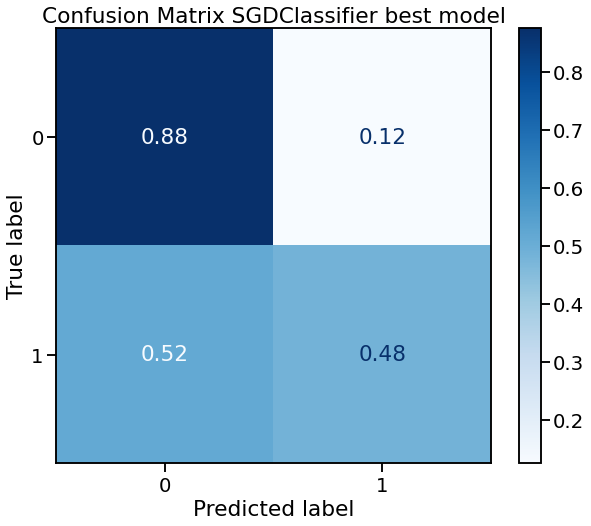

In [12]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_confusion_matrix(
    best_model, X_test_s, y_test,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax
    )
plt.title('Confusion Matrix SGDClassifier best model')
plt.show()

## Ejercicio 3: Árboles de Decisión
---
En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [13]:
random_state = np.random.RandomState(0)

tree = DecisionTreeClassifier(random_state=random_state)
tree.fit(X_train, y_train)

y_train_treepred = tree.predict(X_train)
y_test_treepred = tree.predict(X_test)

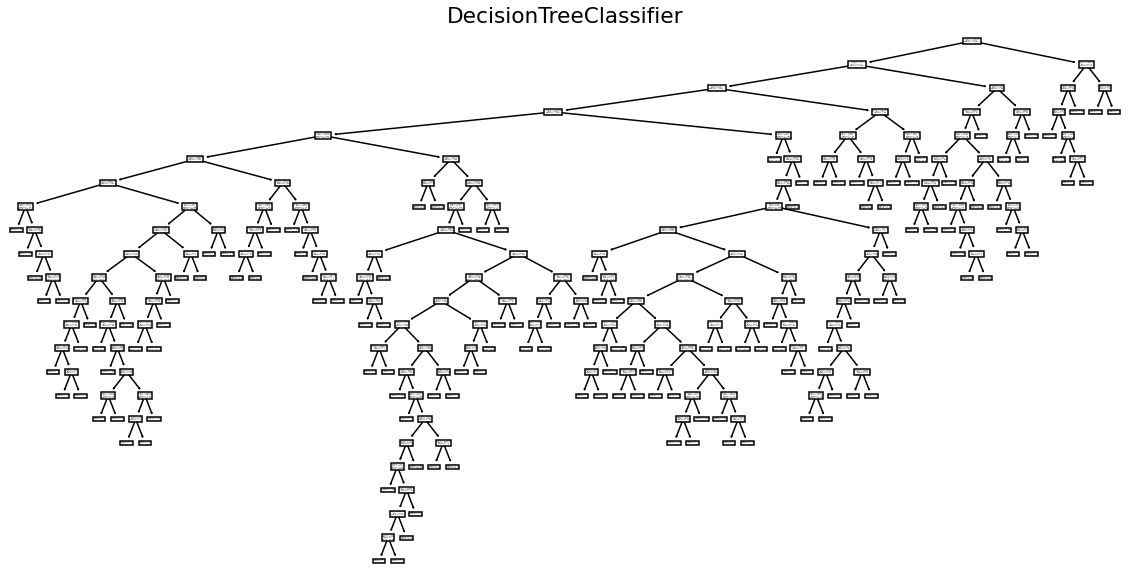

In [14]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1, 1, 1)
plot_tree(tree, ax=ax);
plt.title('DecisionTreeClassifier')
plt.show()

In [15]:
print(classification_report(y_test, y_test_treepred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



Para este modelo se observa un mejor F1 score para la `clase 1`, teniendo un mejor recall y precision. Esto tambien queda evidenciado en la matriz de confusion, con una menor cantidad de falsos negativos y mayor cantidad de verdaderos negativos. 

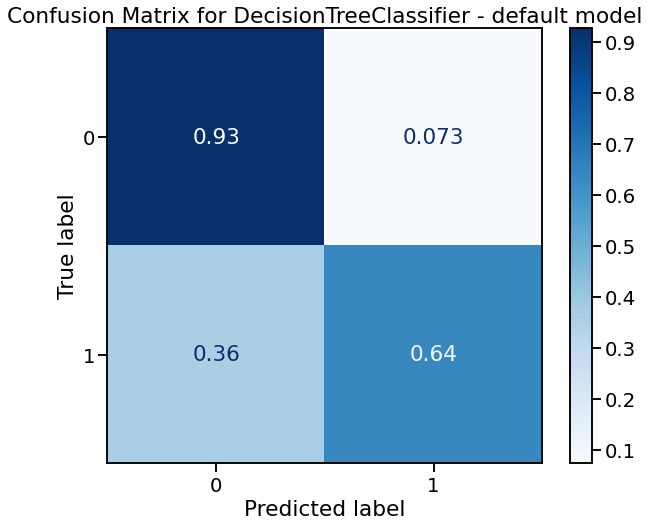

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_confusion_matrix(
    tree, X_test, y_test,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax
  )

plt.title('Confusion Matrix for DecisionTreeClassifier - default model')
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


Se procede a la optimizacion usando la misma metrica que en la anterior para mejorar el tanto la precision como el recall.

In [17]:
fold = 5
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_depth':[None, 8, 16]
    # 'ccp_alpha': np.logspace(-1, -5, 5),
    # 'min_samples_split': range(2, 10),
    # 'min_samples_leaf':range(1,6)
}

model = DecisionTreeClassifier(random_state=0)
cv = GridSearchCV(model, param_grid, scoring='f1', cv=fold)
cv.fit(X_train, y_train);

In [18]:
res_tree = pd.DataFrame(cv.cv_results_)

cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
results = res_tree[cols].sort_values(by=['rank_test_score']).head(10)
results

,rank_test_score,mean_test_score,std_test_score,params
40,1,0.609494,0.050901,"{'criterion': 'entropy', 'max_depth': 16, 'max..."
25,2,0.608409,0.064698,"{'criterion': 'entropy', 'max_depth': None, 'm..."
24,3,0.604083,0.048162,"{'criterion': 'entropy', 'max_depth': None, 'm..."
44,4,0.599399,0.032121,"{'criterion': 'entropy', 'max_depth': 16, 'max..."
46,4,0.599399,0.032121,"{'criterion': 'entropy', 'max_depth': 16, 'max..."
42,4,0.599399,0.032121,"{'criterion': 'entropy', 'max_depth': 16, 'max..."
1,7,0.596179,0.058814,"{'criterion': 'gini', 'max_depth': None, 'max_..."
2,8,0.594595,0.052886,"{'criterion': 'gini', 'max_depth': None, 'max_..."
4,8,0.594595,0.052886,"{'criterion': 'gini', 'max_depth': None, 'max_..."
6,8,0.594595,0.052886,"{'criterion': 'gini', 'max_depth': None, 'max_..."


In [19]:
best_model = cv.best_estimator_
print(best_model)

DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=0)


In [20]:
y_train_pred_t = best_model.predict(X_train)
y_test_pred_t = best_model.predict(X_test)

print('default model')
print(classification_report(y_test, y_test_treepred))
print('---------------------------------------------')
print('best model')
print(classification_report(y_test, y_test_pred_t))

default model
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371

---------------------------------------------
best model
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       313
           1       0.68      0.67      0.68        58

    accuracy                           0.90       371
   macro avg       0.81      0.81      0.81       371
weighted avg       0.90      0.90      0.90       371



Como resultado se obtiene una mejor medida de F1 que el modelo default, e incluso tambien mejor el accuracy para el modelo  `DecisionTreeClassifier`.

Esto se logra limitando la profundidad del arbol para asi eviar el sobreajuste al conjunto de entrenamiento.

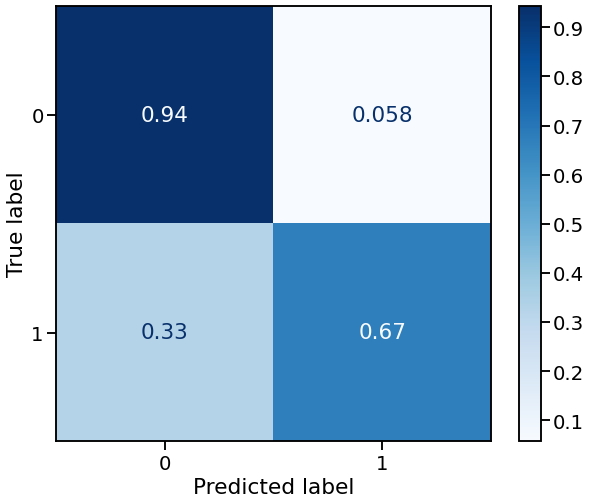

In [21]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plot_confusion_matrix(
    best_model, X_test, y_test,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax
)

plt.show()